# Snippets

short scripts worth keeping

In [2]:
%matplotlib inline
from collections import defaultdict
from constants import *
from os import listdir
from os.path import isfile, join
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
pd.options.display.max_rows = 2001

-----

## All corpora: Fix sent_idx in NLP

In [2]:
def fix_sent_idx(f, store=False):
    print("read", f)
    df = pd.read_pickle(f)
    columns = df.columns.tolist()
    len_old = len(df)
    size_old = df.size

    # create a count for each document
    df_group = pd.DataFrame(df.groupby(HASH).head(1)[HASH]).reset_index(drop=True)
    df_group['count'] = df_group.index

    # append count to original DataFrame
    df = df.merge(df_group[[HASH, 'count']], on=HASH)

    # add document count to sent_idx
    df['sent_idx'] += df['count']
    df = df[columns]
    len_new = len(df)
    size_new = df.size
    assert len_old == len_new
    assert size_old == size_new

    if store:
        print("write", f)
        df.to_pickle(f)

    #return df

In [ ]:
# apply on nlp
path = NLP_PATH
number = None
files = sorted([f for f in listdir(path) if isfile(join(path, f))], key=lambda s: s.lower())
for name in files[:number]:
    if name.startswith('dewac'):
        gc.collect()
        gc.collect()
        f = join(path, name)
        fix_sent_idx(f, store=True)

In [ ]:
# apply on simple ... will not work. better redo simple
path = SMPL_PATH
number = 2
files = sorted([f for f in listdir(path) if isfile(join(path, f))], key=lambda s: s.lower())
for name in files[:number]:
    f = join(path, name)
    df = fix_sent_idx(f, store=True)

In [ ]:
df.groupby(HASH, sort=False).apply(lambda x: x.head(5).append(x.tail(5)))[[SENT_IDX, TOK_IDX, TOKEN]]

-----

## Restoring original document hashes

for *_simple files (after accidental dtype conversion during phrase extraction)

In [ ]:
corpus = 'FAZ'
f = join(NLP_PATH, corpus + '_nlp.pickle')
dfn = pd.read_pickle(f)
f = join(SMPL_PATH, corpus + '_simple.pickle')
dfs = pd.read_pickle(f)

In [ ]:
pd.options.display.max_rows = 2005
dfn.loc[0:500, [HASH, SENT_IDX, TOK_IDX, TOKEN]]

In [ ]:
dfs = dfs.rename(columns={'hash': 'hash_wrong'})
dfs[0:300]
# hm this is bad: first word of document is in wrong order - better redo simple

In [ ]:
#dfs_u = dfs[SENT_IDX].unique()
dfng = dfn.groupby(['hash', SENT_IDX]).head(1)
dfsg = dfs.groupby(['hash_wrong', SENT_IDX]).head(1)

In [ ]:
dfsg[['hash_wrong', SENT_IDX, POS]]

In [ ]:
# 1) joining on index: -> not working
# 2) joining 
dfx = dfs.join(dfn[HASH])
dfx['diff'] = (dfx['hash_wrong'] - dfx[HASH]).abs()
dfx[[HASH, 'hash_wrong', 'diff']]

In [ ]:
dfx[dfx.POS == 'NPHRASE']

------

## preprocess FAZ

### Join FAZ and FAZ2 and remove duplicates

In [ ]:
fname1 = 'FAZ.pickle'
fpath1 = join(ETL_PATH, fname1)
df1 = pd.read_pickle(fpath1)
fname2 = 'FAZ2.pickle'
fpath2 = join(ETL_PATH, fname2)
df2 = pd.read_pickle(fpath2)

df1['new'] = False
combined = pd.concat([df1, df2])
c1 = combined
c2 = combined[~combined.duplicated(subset=[TITLE])]
c1.shape, c2.shape

In [ ]:
df = c2
del c1, c2, df1, df2
df = df[~df.subset.isin(
    [
        'angst-in-chemnitz-und-arroganz-im-dfb-team-15762511.html',
        'faz-net-sprinter-dumm-aber-sexy-15758998.html',
        'faz-net-sprinter-gehoert-sachsen-noch-zu-deutschland-15760532.html',
        'reise',
        #'rhein-main',
        'sport',
        #'technik-motor',
    ]
)]
df.groupby('subset').describe()

-------

## preprocess Wikipedia

### Wikipedia - phrase extraction

#### - applying phrases on simple

In [ ]:
goodids = pd.read_pickle(join(ETL_PATH, 'dewiki_good_ids.pickle'))

p = pd.read_pickle(join(ETL_PATH, 'dewiki_phrases_joined.pickle'))
ps = set(p)
bad = {
    'ab', 'seit',
}
def ngrams(ser):
    if ser[0] not in bad:
        s = ser.str.cat(sep='_')
        size = len(ser)
        while size > 1:
            if (s in ps):
                return s, size
            s = s.rsplit('_', 1)[0]
            size -= 1
    return np.nan, 0

ps

In [ ]:
pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(SMPL_PATH)
                if (isfile(join(SMPL_PATH, f)) and pattern.match(f))])

for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(SMPL_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    df = df[df.hash.isin(goodids.index)]
    df = df.reset_index(drop=True)
    #df = df[:10_000]
    df['__2'] = df.token.shift(-1)
    df['__3'] = df.token.shift(-2)
    df['__4'] = df.token.shift(-3)
    df['__5'] = df.token.shift(-4)
    d = df[[TOKEN, '__2', '__3', '__4', '__5']].progress_apply(ngrams, axis=1)
    d = pd.DataFrame.from_records(d.tolist(), columns=['phrase', 'length'])
    mask = ~d.phrase.isnull()
    df = pd.concat([df, d], axis=1).drop(['__2', '__3', '__4', '__5'], axis=1)
    df.loc[mask, TOKEN] = df.loc[mask, 'phrase']
    df.loc[mask, POS] = 'NPHRASE'
    lv = df.length.values
    keep = np.ones_like(lv, dtype=bool)
    length = len(keep)
    for i, v in enumerate(lv):
        if v > 0:
            for j in range(i+1, min(i+v, length)):
                if lv[j] == 0:
                    keep[j] = False
    df['keep'] = keep
    df = df[df.keep].drop(['phrase', 'length', 'keep'], axis=1)
    df.to_pickle(f+'_x')


In [ ]:
print(df.dtypes)
df

#### phrases from Wikipedia titles and building lemmatized phrase-token

In [2]:
# lemmatized wiki_phrases (titles only, no links or categories)
goodids = pd.read_pickle(join(ETL_PATH, 'dewiki_good_ids.pickle'))
goodids

hash_nlp
 8952056961092092653                                         Alan Smithee
 598046625986755870                                              Actinium
 8442369265370766621                                              Ang Lee
-5325279570187525080                                            Anschluss
 5107548614255273253                                        Aussagenlogik
-6810310479569543740                                    Anthony Minghella
-291419119128528545                                US-amerikanischer Film
-686601136003585762                             Vorsätze für Maßeinheiten
-928617659304474122                         Abkürzungen/Gesetze und Recht
-4698193686953049209    Liste von Unternehmen mit Namensherkunftserklä...
-1053298580323217908                                             ISO 4217
-2937308267488324601                                         Achsensprung
 1251422564758405786                                     Alfred Hitchcock
-5850162359302794440         

In [4]:
pattern = re.compile(r'dewiki')
files = sorted([f for f in listdir(NLP_PATH)
                if isfile(join(NLP_PATH, f)) and pattern.match(f)
               ])

def lemmatized_title_phrase(grp):
    sent_id = grp.iloc[0, 1]
    grp = grp.reset_index(drop=True)
    doc_len = len(grp)
    try:
        first_lf = grp.text[grp.text == '\n'].index[0]
        grp = grp.head(first_lf)
        text = '_'.join(grp.text)
        token = '_'.join(grp.token)
    except:
        token = text = np.nan
    title_len = len(grp)
    dic = dict(sent_idx=int(sent_id), text=text, token=token, doc_len=doc_len, title_len=title_len)
    return pd.Series(dic)


titles = []
for name in files[:]:
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    f = join(NLP_PATH, corpus + '.pickle')
    df = (
        pd.read_pickle(f)[[HASH, SENT_IDX, TEXT, TOKEN]]
        .query('hash in @goodids.index')
        .groupby(HASH, sort=False)
        .apply(lemmatized_title_phrase)
        .dropna(how='any')
        .astype({'sent_idx': np.int32})
    )
    titles.append(df)
    del df
    gc.collect()

df = pd.concat(titles)
del titles
gc.collect()
gc.collect()

df

dewiki_new_0_49999_nlp, dewiki_new_1000000_1049999_nlp, dewiki_new_100000_149999_nlp, dewiki_new_1050000_1099999_nlp, dewiki_new_1100000_1149999_nlp, dewiki_new_1150000_1199999_nlp, dewiki_new_1200000_1249999_nlp, dewiki_new_1250000_1299999_nlp, dewiki_new_1300000_1349999_nlp, dewiki_new_1350000_1399999_nlp, dewiki_new_1400000_1449999_nlp, dewiki_new_1450000_1499999_nlp, dewiki_new_1500000_1549999_nlp, dewiki_new_150000_199999_nlp, dewiki_new_1550000_1599999_nlp, dewiki_new_1600000_1649999_nlp, dewiki_new_1650000_1699999_nlp, dewiki_new_1700000_1749999_nlp, dewiki_new_1750000_1799999_nlp, dewiki_new_1800000_1849999_nlp, dewiki_new_1850000_1899999_nlp, dewiki_new_1900000_1949999_nlp, dewiki_new_1950000_1999999_nlp, dewiki_new_2000000_2049999_nlp, dewiki_new_200000_249999_nlp, dewiki_new_2050000_2099999_nlp, dewiki_new_2100000_2149999_nlp, dewiki_new_2150000_2199999_nlp, dewiki_new_2200000_2249999_nlp, dewiki_new_250000_299999_nlp, dewiki_new_300000_349999_nlp, dewiki_new_350000_399999_n

,sent_idx,text,token,doc_len,title_len
hash,,,,,
8952056961092092653,1,Alan_Smithee,Alan_Smithee,747,2
598046625986755870,44,Actinium,Actinium,866,1
8442369265370766621,98,Ang_Lee,ANG_Lee,1632,2
-5325279570187525080,181,Anschluss,Anschluss,413,1
5107548614255273253,199,Aussagenlogik,Aussagenlogik,7211,1
-6810310479569543740,599,Anthony_Minghella,Anthony_Minghella,637,2
-291419119128528545,636,US-amerikanischer_Film,us-amerikanisch_Film,2992,2
-686601136003585762,767,Vorsätze_für_Maßeinheiten,Vorsatz_für_Maßeinheit,992,3
-928617659304474122,829,Abkürzungen/Gesetze_und_Recht,Abkürzungen/Gesetz_und_Recht,167,3


In [5]:
df.to_pickle(join(ETL_PATH, 'dewiki_phrases_lemmatized.pickle'))

#### - learning phrases from titles

In [ ]:
titles = []

def unique(ser):
    return ser.dropna().str.strip().unique()

f = 'dewiki_links.pickle'
dfl = pd.read_pickle(join(ETL_PATH, f))
f = 'dewiki_categories.pickle'
dfc = pd.read_pickle(join(ETL_PATH, f))

print(1, end=', ')
titles.append(unique(dfl.norm))
# do NOT use dfl.category -> it contains a couple of weird phrases
print(2, end=', ')
titles.append(unique(dfc.category))
del dfc, dfl
gc.collect()
gc.collect()

pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(ETL_PATH)
                if (isfile(join(ETL_PATH, f)) and pattern.match(f))])

for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    f = join(ETL_PATH, corpus + '.pickle')
    titles.append(unique(pd.read_pickle(f)[TITLE]))

print(titles)
df = pd.DataFrame(np.unique(np.hstack(titles)), columns=['phrase'])
del titles
gc.collect()
gc.collect()

print(df.head())
df['length'] = df.phrase.apply(lambda x: x.count(' ') + 1)
df = df[(df.length > 1) & (df.length < 6)]
r = re.compile(r'^[a-zA-Z0-9_äöüÄÖÜß]')
df = df[df.phrase.str.match(r)]

df = df['phrase']
print('expand')
df = df.str.split(' ', expand=True)
print('write')
df.to_pickle(join(ETL_PATH, 'dewiki_phrases.pickle'))
df = df.progress_apply(lambda x: x.str.cat(sep='_'), axis=1)
df.to_pickle(join(ETL_PATH, 'dewiki_phrases_joined.pickle'))

['dewiki_new_0_49999_nlp.pickle', 'dewiki_new_1000000_1049999_nlp.pickle', 'dewiki_new_100000_149999_nlp.pickle', 'dewiki_new_1050000_1099999_nlp.pickle', 'dewiki_new_1100000_1149999_nlp.pickle', 'dewiki_new_1150000_1199999_nlp.pickle', 'dewiki_new_1200000_1249999_nlp.pickle', 'dewiki_new_1250000_1299999_nlp.pickle', 'dewiki_new_1300000_1349999_nlp.pickle', 'dewiki_new_1350000_1399999_nlp.pickle', 'dewiki_new_1400000_1449999_nlp.pickle', 'dewiki_new_1450000_1499999_nlp.pickle', 'dewiki_new_1500000_1549999_nlp.pickle', 'dewiki_new_150000_199999_nlp.pickle', 'dewiki_new_1550000_1599999_nlp.pickle', 'dewiki_new_1600000_1649999_nlp.pickle', 'dewiki_new_1650000_1699999_nlp.pickle', 'dewiki_new_1700000_1749999_nlp.pickle', 'dewiki_new_1750000_1799999_nlp.pickle', 'dewiki_new_1800000_1849999_nlp.pickle', 'dewiki_new_1850000_1899999_nlp.pickle', 'dewiki_new_1900000_1949999_nlp.pickle', 'dewiki_new_1950000_1999999_nlp.pickle', 'dewiki_new_2000000_2049999_nlp.pickle', 'dewiki_new_200000_249999_n

In [ ]:
df['length'] = df.phrase.apply(lambda x: x.count(' ') + 1)
df = df[(df.length > 1) & (df.length < 6)]
r = re.compile(r'^[a-zA-Z0-9_äöüÄÖÜß]')
df = df[df.phrase.str.match(r)]

df = df['phrase']
print('expand')
df = df.str.split(' ', expand=True)

In [ ]:
print('write')
df.to_pickle(join(ETL_PATH, 'dewiki_phrases.pickle'))
df = df.progress_apply(lambda x: x.str.cat(sep='_'), axis=1)
df.to_pickle(join(ETL_PATH, 'dewiki_phrases_joined.pickle'))

### replace document hashes with updates (Wikipedia)

In [ ]:
pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(ETL_PATH)
                if (isfile(join(ETL_PATH, f)) and pattern.match(f))])

mappings = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus)
    
    f = join(NLP_PATH, corpus + '_nlp.pickle')
    dfnlp = (
        pd.read_pickle(f)
        .groupby(HASH).head(1)[[HASH, TEXT]]
        .reset_index()
    )
    f = join(ETL_PATH, corpus + '.pickle')
    dfetl = (
        pd.read_pickle(f)
        .astype({
            DATASET: "category",
            SUBSET: "category", 
        })
        .reset_index()
        .join(dfnlp, rsuffix='_nlp')
    )
    dfjoin = dfetl[[HASH, TITLE, 'hash_nlp', 'text_nlp']].copy()
    dfjoin['equal_start'] = dfjoin.apply(lambda x: x.title.startswith(x.text_nlp), axis=1)
    #dfjoin['first_token'] = None
    #dfjoin['first_token'] = dfjoin.title.str.split(expand=True)
    #dfjoin['equal'] = (dfjoin.text_nlp == dfjoin.first_token)
    assert dfjoin.equal_start.sum() == len(dfjoin)
    dfetl = (
        dfetl
        .set_index('hash_nlp', drop=True)
        .drop(['text_nlp', 'hash', 'index'], axis=1)
    )
    dfetl.to_pickle(f)
    mappings.append(dfjoin[['hash', 'hash_nlp']])
    
dfmap = pd.concat(mappings)
dfmap = dfmap.set_index(HASH)['hash_nlp']
dfmap.to_pickle(join(ETL_PATH, 'dewiki_hashmap.pickle'))
pd.read_pickle(join(ETL_PATH, 'dewiki_hashmap.pickle'))

In [ ]:
def replace_docid(f):
    print(f)
    df = (
        pd.read_pickle(join(ETL_PATH, f))
        .join(dfmap, on='doc_id')
        .drop('doc_id', axis=1)
    )
    df.to_pickle(join(ETL_PATH, f))

replace_docid('dewiki_categories.pickle')
replace_docid('dewiki_links.pickle')

### Find bad encoded articles (Wikipedia)

In [4]:
pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(join(ETL_PATH, 'deprecated'))
                if (isfile(join(ETL_PATH, 'deprecated', f)) and pattern.match(f))])

In [6]:
# take samples from the corpus as training set
samples = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(ETL_PATH, 'deprecated', corpus + '.pickle.gz')
    df = pd.read_pickle(f)
    df = df.loc[df.subset == 'ARTICLE']
    df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    sample_size = len(df) // 5_000
    print(len(df), sample_size)
    samples.append(df[[TITLE, TEXT]].sample(sample_size, random_state=1))

samples = pd.concat(samples)

dewiki_01_0, 20763 4
dewiki_01_1, 17477 3
dewiki_01_2, 18986 3
dewiki_01_3, 18505 3
dewiki_02_0, 36191 7
dewiki_02_1, 35342 7
dewiki_03, 68750 13
dewiki_04, 66730 13
dewiki_05, 63691 12
dewiki_06, 63769 12
dewiki_07, 63046 12
dewiki_08, 58753 11
dewiki_09, 58077 11
dewiki_10, 57080 11
dewiki_11, 57510 11
dewiki_12, 59642 11
dewiki_13, 58799 11
dewiki_14, 58255 11
dewiki_15, 58331 11
dewiki_16, 58485 11
dewiki_17, 60547 12
dewiki_18, 61059 12
dewiki_19, 58988 11
dewiki_20, 57332 11
dewiki_21, 58544 11
dewiki_22, 57563 11
dewiki_23, 55763 11
dewiki_24, 57419 11
dewiki_25, 54563 10
dewiki_26, 56818 11
dewiki_27, 55053 11
dewiki_28, 52670 10
dewiki_29, 56199 11
dewiki_30, 59595 11
dewiki_31, 59401 11
dewiki_32, 59660 11
dewiki_33, 60684 12
dewiki_34, 61350 12
dewiki_35, 60312 12
dewiki_36, 61468 12
dewiki_37, 52317 10


In [7]:
# remove a few problematic documents from training set
removable = [
    841808810294450851,
    -4692350076498843548,
    -8049734301321653789,
    -4131305296668036145,
    -8810233646059586724,
    2361495353241257464,
    2496670190106332015,
    7370294376993591077,
    -7758054498192490695,
    -4994773231110680494,
    2192724857258762575,
    1420892661644474111,
]
samples = samples[~samples.index.isin(removable)]
trainset = df[TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

defaultdict(<class 'int'>, {'c': 21.0, 'h': 31.0, 'a': 50.0, 'r': 62.0, 'l': 31.0, 'e': 121.0, 's': 50.0, ' ': 135.0, 'v': 7.0, 'u': 30.0, 'g': 22.0, 'n': 72.0, 'i': 63.0, 't': 49.0, 'd': 38.0, 'm': 22.0, 'f': 13.0, 'o': 25.0, 'p': 9.0, ':': 1.0, '\n': 6.0, '(': 2.0, 'ä': 3.0, ')': 2.0, '1': 7.0, '7': 1.0, '5': 1.0, '9': 3.0, '–': 0.0, '8': 2.0, '3': 1.0, ',': 7.0, '-': 3.0, 'k': 11.0, '*': 0.0, '0': 4.0, 'é': 0.0, '4': 1.0, '.': 9.0, 'ü': 4.0, 'w': 10.0, 'b': 16.0, '6': 1.0, '²': 0.0, 'ł': 0.0, 'ż': 0.0, 'y': 2.0, 'z': 8.0, 'ń': 0.0, 'j': 2.0, '2': 3.0, '=': 6.0, 'ß': 1.0, '„': 0.0, '“': 0.0, 'ó': 0.0, '†': 0.0, 'ö': 2.0, ';': 0.0, 'q': 0.0, 'x': 0.0, '&': 0.0, '?': 0.0, 'š': 0.0, 'č': 0.0, "'": 0.0, 'ž': 0.0, '/': 0.0, '"': 0.0, '|': 0.0, '}': 0.0, 'ć': 0.0, 'ô': 0.0, 'â': 0.0, 'ç': 0.0, '’': 0.0, 'ë': 0.0, '…': 0.0, 'í': 0.0, 'á': 0.0, 'ř': 0.0, 'ň': 0.0, 'ý': 0.0, 'ě': 0.0, '~': 0.0, '³': 0.0, '[': 0.0, '_': 0.0, '+': 0.0, '#': 0.0, '%': 0.0, ']': 0.0, 'è': 0.0, 'ș': 0.0, 'ă': 0.0,

### collecting links from Wikipedia in a separate DataFrame

In [ ]:
# collecting links from Wikipedia in a separate DataFrame
LINK_LIST = []
TAGS_LIST = []

def collect_links(df):
    for doc_id, links in df[LINKS].iteritems():
        if isinstance(links, str):
            LINK_LIST.append((doc_id, links))
        else:
            for link in links:
                LINK_LIST.append((doc_id, *link))

def collect_tags(df):
    for doc_id, categories in df[TAGS].iteritems():
        if isinstance(categories, str):
            TAGS_LIST.append((doc_id, categories))
        else:
            for category in categories:
                TAGS_LIST.append((doc_id, category))

pattern = re.compile(r'^dewiki_\d')
files = sorted([f for f in listdir(FULL_PATH)
                if isfile(join(FULL_PATH, f))
                and pattern.match(f)
               ])

for name in files:
    fname = join(ETL_PATH, name)
    print(fname)
    df = pd.read_pickle(fname)
    collect_links(df)
    collect_tags(df)

del df
df_links = pd.DataFrame.from_records(LINK_LIST, columns=['doc_id', 'link', 'norm', 'category'])
del LINK_LIST
df_tags = pd.DataFrame.from_records(TAGS_LIST, columns=['doc_id', 'category'])
del TAGS_LIST
df_links.to_pickle(join(ETL_PATH, 'dewiki_links.pickle'))
df_tags.to_pickle(join(ETL_PATH, 'dewiki_categories.pickle'))

### splitting the largest files from the wikipedia corpus to parallelize the nlp pipeline

In [ ]:
# splitting the largest files from the wikipedia corpus to parallelize the nlp pipeline
fname = 'dewiki_01.pickle'
fpath = join(ETL_PATH, fname)
df = pd.read_pickle(fpath)
split = 25*1000
#split *= 2
dfs = [df[:1*split], 
       #df[1*split:], 
       df[1*split:2*split], 
       df[2*split:3*split], 
       df[3*split:]
      ]
length = sum([len(d) for d in dfs])
assert len(df) == length
df.shape, [d.shape for d in dfs]
fsplit = fpath.rsplit('.', 1)
for i, d in enumerate(dfs):
    f = "{}_{:d}.{}".format(fsplit[0], i, fsplit[1])
    print(f)
    d.to_pickle(f)

-------

## preprocess Dewac

In [15]:
pattern = re.compile(r'dewac_\d')
files = sorted([f for f in listdir(ETL_PATH)
                if (isfile(join(ETL_PATH, f)) and pattern.match(f))])

In [16]:
# take samples from the corpus as training set
samples = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(ETL_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    #df = df.loc[df.subset == 'ARTICLE']
    #df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    sample_size = len(df) // 5_000
    print(len(df), sample_size)
    samples.append(df[[TITLE, TEXT]].sample(sample_size, random_state=1))

samples = pd.concat(samples)

dewac_01, 54907 10
dewac_02, 54991 10
dewac_03, 54977 10
dewac_04, 54829 10
dewac_05, 54968 10
dewac_06, 54986 10
dewac_07, 54966 10
dewac_08, 54959 10
dewac_09, 54986 10
dewac_10, 54560 10
dewac_11, 54990 10
dewac_12, 54999 10
dewac_13, 54987 10
dewac_14, 54999 10
dewac_15, 54997 10
dewac_16, 54988 10
dewac_17, 54953 10
dewac_18, 54807 10
dewac_19, 54946 10
dewac_20, 54950 10
dewac_21, 54944 10
dewac_22, 54818 10
dewac_23, 54980 10
dewac_24, 54993 10
dewac_25, 54976 10
dewac_26, 54962 10
dewac_27, 54996 10
dewac_28, 54994 10
dewac_29, 54991 10
dewac_30, 54975 10
dewac_31, 54937 10
dewac_32, 48560 9


In [17]:
samples[TEXT]

hash
-8157526149998639139    Moderator Volker Matthies mit Experte PD Dr. A...
-8139041734586718076    Zubereitung Den Lachs antauen laßen, in Würfel...
-6942140900391567610    Wussten Sie, dass die StadtBibliothek Köln die...
-8911096388020119024    29.06.05: Enquete-Kommission fordert Verbesser...
 6240926672015106313    Würzburg (rk/ag) Der Streit zwischen CDU und C...
 1959711681121568241    Ein besonders großes Danke für die Hilfe beim ...
-5830768473555351539    In Niedersachsen gibt es zur Zeit 993.000 Schü...
 9196780305889762322    Was geht uns das an: Christen und Politik Mona...
-1859898204671528775    In seiner literarischen Reportage "Die Hundees...
 4418799350836099921    Was Shakespeare nie zu schreiben wagte Die Fra...
 4430206916370824726    Neuer Chef des Planetariums plant digitale Tec...
 7803819644630133892    Nicht in jedem Fall ist bei ausländischen Küns...
-4630582756677073888    Zukunftsmanifest der IG Metall redet Entsolida...
-8857524272526221661    Protestbr

In [19]:
list(samples.index)

[-8157526149998639139,
 -8139041734586718076,
 -6942140900391567610,
 -8911096388020119024,
 6240926672015106313,
 1959711681121568241,
 -5830768473555351539,
 9196780305889762322,
 -1859898204671528775,
 4418799350836099921,
 4430206916370824726,
 7803819644630133892,
 -4630582756677073888,
 -8857524272526221661,
 9081937174333137614,
 1779036211262207863,
 6610278774841223644,
 2352018544064297518,
 -2600393555558806245,
 -6618185189525628783,
 5282786949064607814,
 6305502385560154586,
 -6383615109664325842,
 4674913760409437023,
 -5924990954937343321,
 5529182561793509790,
 2171365852785009044,
 -8105316796683834251,
 5278582610314669683,
 3412739076452589341,
 -2030175838358044016,
 -2905528300760475504,
 -5470432379184620388,
 -1712703150380858845,
 4021966044005632984,
 1614839259918774512,
 -3168163503274198537,
 -1396870867404827402,
 -9213977513171831737,
 -3106483392389176943,
 -475735757977787014,
 8971301929692358079,
 -1910920720034530581,
 7753234162230409350,
 508125222

In [18]:
trainset = df[TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

defaultdict(<class 'int'>, {'1': 2.0, '7': 0.0, '.': 9.0, '0': 2.0, '5': 0.0, '2': 1.0, '4': 0.0, ',': 8.0, ' ': 138.0, ':': 1.0, 'l': 30.0, 'a': 45.0, 'n': 82.0, 'd': 39.0, 'b': 17.0, 'e': 131.0, 'r': 60.0, 'i': 65.0, 't': 51.0, 'u': 33.0, 'h': 35.0, 'm': 21.0, 'f': 14.0, 's': 52.0, 'o': 21.0, 'v': 7.0, '/': 0.0, 'x': 0.0, 'ß': 1.0, 'w': 11.0, 'z': 10.0, 'k': 11.0, 'p': 7.0, 'ü': 5.0, 'g': 25.0, 'ä': 4.0, 'c': 23.0, '&': 0.0, 'q': 0.0, ';': 0.0, 'j': 1.0, '(': 1.0, ')': 1.0, '-': 2.0, '8': 0.0, '9': 1.0, 'y': 0.0, '6': 0.0, '3': 0.0, 'ö': 2.0, '"': 1.0, '=': 0.0, '\x96': 0.0, '\x84': 0.0, '\x93': 0.0, '?': 0.0, '+': 0.0, '*': 0.0, '#': 0.0, '©': 0.0, '!': 0.0, '@': 0.0, '[': 0.0, ']': 0.0, '<': 0.0, '_': 0.0, '´': 0.0, '|': 0.0, '»': 0.0, '«': 0.0, "'": 0.0, '`': 0.0, 'é': 0.0, '>': 0.0, '%': 0.0, '^': 0.0, '°': 0.0, '\x85': 0.0, '§': 0.0, '·': 0.0, '\xad': 0.0, 'à': 0.0, '\x9b': 0.0, '\x8b': 0.0, 'â': 0.0, '\x82': 0.0, '¬': 0.0, 'è': 0.0, 'î': 0.0, '\x80': 0.0, 'ó': 0.0, '\x94': 0.0,

In [20]:
# comparing with FOCUS score
doc_freq = {'b': 17.0, 'e': 134.0, 'i': 64.0, 'm': 20.0, ' ': 137.0, 'h': 35.0, 'z': 10.0, 'ö': 2.0, 'l': 33.0, '-': 4.0, 'k': 13.0, 'a': 47.0, 'u': 31.0, 'f': 13.0, 's': 53.0, 't': 52.0, 'd': 39.0, 'r': 58.0, 'c': 24.0, 'g': 22.0, 'n': 81.0, 'o': 26.0, '.': 9.0, 'w': 10.0, 'ü': 5.0, 'v': 7.0, ':': 1.0, ',': 6.0, 'p': 11.0, 'ä': 4.0, '8': 0.0, '1': 1.0, '2': 1.0, '0': 1.0, 'j': 1.0, '–': 0.0, 'ß': 1.0, '9': 0.0, '\n': 3.0, 'y': 1.0, '6': 0.0, '5': 0.0, '„': 0.0, '“': 0.0, '?': 0.0, '’': 0.0, '7': 0.0, 'x': 0.0, '(': 0.0, ')': 0.0, '*': 0.0, '3': 0.0, '4': 0.0, 'q': 0.0, '&': 0.0, ';': 0.0, '"': 0.0, '!': 0.0, '@': 0.0, '/': 0.0, "'": 0.0, '+': 0.0, 'é': 0.0}

distance = 0
for k in doc_freq.keys():
    distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
int(distance)

49

In [ ]:
def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)

good_ids = []
bad = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(TMP_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    #df = df.loc[df.subset == 'ARTICLE']
    #df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    df['enc_score'] = df[TEXT].apply(encryption_score)
    # keep articles with distance < 400
    good_ids.append(df.loc[df.enc_score < 400, TITLE])
    bad.append(df[df.enc_score >= 400])


In [20]:
bad = pd.concat(bad)
good_ids = pd.concat(good_ids)
good_ids.to_pickle(join(TMP_PATH, 'dewac_good_ids.pickle'))
len(bad) / (len(good_ids)+len(bad))

0.002495617542615866

In [ ]:
bad[TEXT].tolist()

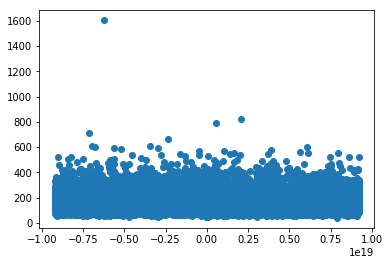

In [11]:
# evaluate results
plt.scatter(df.index, df.enc_score)

(array([1.1291e+04, 2.6785e+04, 8.8010e+03, 1.3570e+03, 2.2700e+02,
        6.5000e+01, 2.3000e+01, 7.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  39. ,  117.3,  195.6,  273.9,  352.2,  430.5,  508.8,  587.1,
         665.4,  743.7,  822. ,  900.3,  978.6, 1056.9, 1135.2, 1213.5,
        1291.8, 1370.1, 1448.4, 1526.7, 1605. ]),
 <a list of 20 Patch objects>)

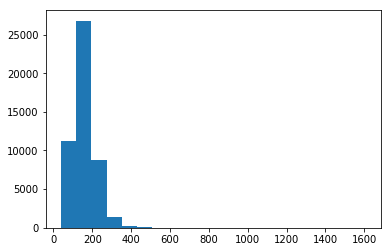

In [12]:
plt.hist(df.enc_score, bins=20)